In [22]:
%matplotlib inline

# define relevant packages; among others: JIRA API
import pandas as pd
import numpy as np
from jira import JIRA 
import matplotlib.pyplot as plt

import seaborn as sns


# ToDos
- [ ] create filters and apply them to a dataframe wo/changing the dataframe itself 

/Example:/
```
price_filter = df.loc[:, 'price'] <= 3000000
df.loc[price_filter, 'price'].hist(bins = 30)
```
- [ ] measure balance sheet for provided hours and billed hours

 # AERQ Business Owner Reporting Notebook

 ## CMS related reports

In [25]:
# variable definitions in first place
# for JIRA/trackspace connection
trackSpace = 'https://trackspace.lhsystems.com'
bcUser = 'u293733'
bcPw = '(Uw^lLG>^gl8'


### Procon hours

#### Monthly booked hours in a table

---
** Attention: currently, the below figures come from a test excel sheet only! **
** They do currently not reflect any real spent CMS effort **

---

In [4]:
df_procon = pd.read_excel('./AERQ.commercials.overview.xlsx', sheet_name='Procon LTE Data', usecols="A:L")
df_procon.shape

(209, 12)

In [5]:
print (df_procon['LE-Bezeichnung'].value_counts())
#from all Procon LEs, filter the CMS entries only
cms_filter = df_procon['LE-Bezeichnung'] == 'AERQ Product'
# and check, how many entries are affected
cms_filter.shape


AERQ Consulting                   51
AERQ ModServer                    51
AERQ SW Architect & Deploy FRA    49
AERQ Product                      31
AERQ Sales Support                17
RFC BC Core Mod Experte            5
AERQ OpsUI BUD                     4
RFC BC Core Mod Sen Entw           1
Name: LE-Bezeichnung, dtype: int64


(209,)

In [6]:
# get the number of employees that have booked hours for the filtered Procon LE
no_staff = len(df_procon.loc[cms_filter, ['Mitarbeiter-Name']].value_counts())
# sum up the booked hours and print 'em out
no_hours = df_procon.loc[cms_filter, ['Stunden']].sum()
print(str(no_staff)+' colleagues have booked a total of '+str(no_hours))
df_procon.loc[cms_filter, :].groupby(by=['Export-Datum', 'Mitarbeiter-Name'])[['Stunden']].sum()

6 colleagues have booked a total of Stunden    153.47
dtype: float64


Stunden
Export-Datum Mitarbeiter-Name              
2020-06-26   Kohlert, Christian        5.50
             Pietzner, Mark            8.00
             Thiel, Gregor Michael     2.00
             Weil, Mario              33.50
2020-07-29   Kohlert, Christian        5.00
             Pietzner, Mark            1.00
2020-08-27   Droege, Eberhard          2.00
             Kohlert, Christian        1.00
             Pietzner, Mark           23.90
2020-09-28   Pietzner, Mark           11.00
             Thiel, Gregor Michael     5.50
             Weil, Mario               1.00
2020-10-27   Pietzner, Mark            1.00
             Thiel, Gregor Michael     1.00
2020-11-27   Kohlert, Christian       13.42
             Pietzner, Mark            2.00
             Thiel, Gregor Michael     1.50
2020-12-27   Kohlert, Christian       13.42
             Pietzner, Mark            2.00
             Thiel, Gregor Michael     1.50
2021-01-27   Kohlert, Christian        3.00
             Scherf, Sven             15.23

In [7]:
print (df_procon['Stunden'].value_counts())


1.00     22
2.00     14
4.00     13
3.50     12
1.50     11
         ..
32.30     1
16.50     1
23.50     1
9.75      1
37.50     1
Name: Stunden, Length: 89, dtype: int64


#### Monthly booked hours in a chart (2020)

No handles with labels found to put in legend.


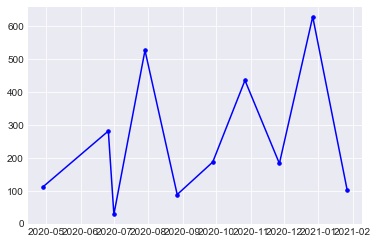

In [8]:
#type(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum())
#plt.style.available
plt.style.use('seaborn-darkgrid')
plt.legend(loc='center right')
plt.plot(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum(), c='b', marker = '.', markersize=7)

 ### Velocity per product in current Sprint: AERQ, DISP, BC

In [9]:
# JQL: retrieve all tickets in current Sprint
search_string = 'project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint'


**JQL Statement**
```
project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint
```

In [10]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, issue.fields.updated, issue.fields.customfield_10233, issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
    issue_table_header = ['Key', 'Summary', 'Created', 'Updated', 'Story Points', 'Status', 'Labels']
    df = pd.DataFrame(issue_table)
    df.columns = issue_table_header
except Exception as e:
    print(e)



#### Velocity table and chart per category

The chart shows tickets in current Sprint

            Story Points      %
Labels                         
AERQ                45.0  46.39
BC                  49.0  50.52
DISP@LH777           3.0   3.09


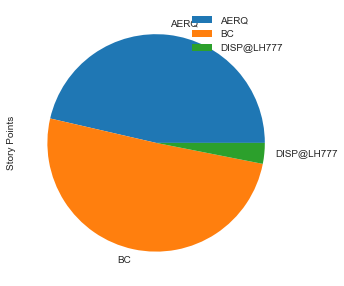

In [11]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


#### Tickets in current Sprint

In [12]:
# Width of the display in characters. If set to None and pandas will correctly auto-detect the width.
pd.set_option('display.width', None)
print (df[['Key', 'Story Points', 'Labels']])

               Key  Story Points      Labels
0   BCIFCPCMS-4493          13.0        AERQ
1   BCIFCPCMS-4524          13.0        AERQ
2   BCIFCPCMS-4540           2.0        AERQ
3   BCIFCPCMS-4509           3.0          BC
4   BCIFCPCMS-4537           5.0        AERQ
5   BCIFCPCMS-4527           5.0          BC
6   BCIFCPCMS-4541           2.0          BC
7   BCIFCPCMS-4536           5.0          BC
8   BCIFCPCMS-4525           5.0          BC
9   BCIFCPCMS-4580           5.0          BC
10  BCIFCPCMS-4549           3.0          BC
11  BCIFCPCMS-4542           1.0        AERQ
12  BCIFCPCMS-4543           3.0  DISP@LH777
13  BCIFCPCMS-4446           8.0          BC
14  BCIFCPCMS-4474          13.0          BC
15  BCIFCPCMS-4581           3.0        AERQ
16  BCIFCPCMS-4494           8.0        AERQ


 ### Velocity per product in refined items: AERQ, DISP, BC

In [28]:
# JQL: get all tickets which have label "refined" and that are in the backlog
search_string = 'project = BCIFCPCMS AND issuetype not in subtaskIssueTypes() AND issuetype != Epic AND resolution = Unresolved AND (Sprint = EMPTY OR Sprint not in (openSprints(), futureSprints())) AND labels in ("refined")'

**JQL Statement**
```
project = BCIFCPCMS AND issuetype not in subtaskIssueTypes() AND issuetype != Epic AND resolution = Unresolved AND (Sprint = EMPTY OR Sprint not in (openSprints(), futureSprints())) AND labels in ("refined")
```

In [29]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, issue.fields.updated, issue.fields.customfield_10233, issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
    issue_table_header = ['Key', 'Summary', 'Created', 'Updated', 'Story Points', 'Status', 'Labels']
    df = pd.DataFrame(issue_table)
    df.columns = issue_table_header
except Exception as e:
    print(e)


#### Velocity table and chart per category

The chart shows refined items in Backlog

            Story Points      %
Labels                         
BC                 549.0  93.85
DISP@LH777          36.0   6.15


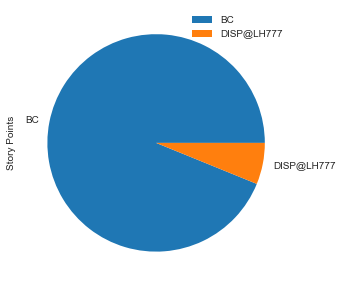

In [30]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in future Sprints: AERQ, DISP, BC

In [13]:
# JQL: get all non-closed tickets from future Sprints (thus: Refined Sprint (doesn't exist any longer; instead, label "refined" is used), existing Sprints > current one)
search_string = 'project = BCIFCPCMS AND Sprint in (futureSprints()) AND status not in (Done, Closed, Resolved) ORDER BY sprint'


**JQL Statement**
```
project = BCIFCPCMS AND Sprint in (futureSprints()) AND status not in (Done, Closed, Resolved) ORDER BY sprint
```

In [14]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, issue.fields.updated, issue.fields.customfield_10233, issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
    issue_table_header = ['Key', 'Summary', 'Created', 'Updated', 'Story Points', 'Status', 'Labels']
    df = pd.DataFrame(issue_table)
    df.columns = issue_table_header
except Exception as e:
    print(e)



#### Velocity table and chart per category

The chart shows tickets in future Sprints (refined items that have already been planned in future Sprints)

        Story Points      %
Labels                     
AERQ            73.0  49.32
BC              75.0  50.68


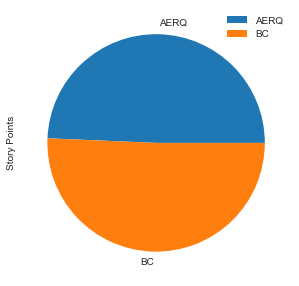

In [15]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in past month per category: AERQ, DISP, BC

In [16]:
from datetime import date, timedelta

previous_month = date.today().replace(day=1) - timedelta(days=1)
# create DataFrame with relevant attributes from which further reports are derived
search_string = ('project = BCIFCPCMS AND '
'status changed TO (resolved, done, closed) '
'AFTER "' + str(previous_month.year) + '/' + str(previous_month.month) + '/' + '01" '
'BEFORE "' + str(previous_month.year) + '/' + str(previous_month.month) + '/' + str(previous_month.day) + '" '
'ORDER BY  updated DESC')


**JQL Statement**
```
project = BCIFCPCMS AND status changed to (resolved, done, closed) after "yyyy/mm-1/1" before "yyyy/mm-1/<end_of_month>" ORDER BY updated DESC" 
```

In [17]:
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, \
                           issue.fields.updated, issue.fields.resolutiondate, \
                           issue.fields.customfield_10233, \
                           issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
    issue_table_header = ['Key', 'Summary', 'Created', \
                          'Updated', 'Resolved', \
                          'Story Points', \
                          'Status', 'Labels']
    df = pd.DataFrame(issue_table)
    df.columns = issue_table_header
except Exception as e:
    print(e)


#### Velocity table and chart per category

1 2021
            Story Points      %
Labels                         
AERQ                16.0  15.09
BC                  80.0  75.47
DISP@LH777          10.0   9.43


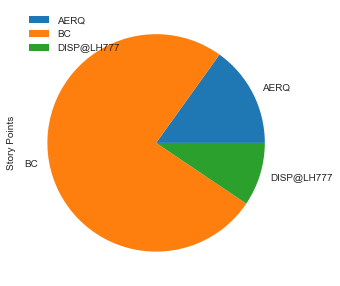

In [18]:
    # group selected tickets (previous month) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print (str(previous_month.month) + ' ' + str(previous_month.year))
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in current month per category: AERQ, DISP, BC

In [19]:
current_month = date.today()
search_string = ('project = BCIFCPCMS AND '
'status changed TO (resolved, done, closed) '
'AFTER "' + str(current_month.year) + '/' + str(current_month.month) + '/' + '01" '
'BEFORE "' + str(current_month) + '" '
'ORDER BY  updated DESC')

**JQL Statement**
```
project = BCIFCPCMS AND status changed to (resolved, done, closed) after "yyyy/mm/1" before "yyyy/mm-1/<today>" ORDER BY updated DESC 
```

In [20]:
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    issue_table_header = ['Key', 'Summary', 'Created', \
                        'Updated', 'Resolved', \
                        'Story Points', \
                        'Status', 'Labels']
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, \
                           issue.fields.updated, issue.fields.resolutiondate, \
                           issue.fields.customfield_10233, \
                           issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
#deal with the situation that in current month no tickets have been processed so far
#(thus, that issue_table is empty)        
    if issue_table != []:
        df = pd.DataFrame(issue_table)
        df.columns = issue_table_header
except Exception as e:
    print(e)


#### Velocity table and chart per category

2 2021
            Story Points      %
Labels                         
AERQ                68.0  61.82
BC                  31.0  28.18
DISP@LH777          11.0  10.00


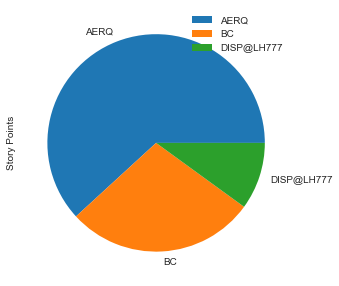

In [21]:
    # group selected tickets (current month) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    if df.empty:
        print('In current month, no tickets have been processed so far')
    else:
        df_new = df.groupby('Labels')[['Story Points']].sum()
        # add a Velocity's percentage value per category
        df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
        print (str(current_month.month) + ' ' + str(current_month.year))
        print(df_new)
        plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))
